10:12:10 redisvl.index.index INFO   Index already exists, not overwriting.
10:12:10 redisvl.index.index INFO   Index already exists, not overwriting.
10:12:11 redisvl.index.index INFO   Index already exists, not overwriting.
10:12:11 redisvl.index.index INFO   Index already exists, not overwriting.
10:12:11 redisvl.index.index INFO   Index already exists, not overwriting.


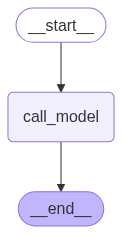

In [ ]:
import getpass
import os
from dotenv import load_dotenv
from langchain_openai import OpenAIEmbeddings
# from langgraph.store.redis import RedisStore
from langgraph.store.redis import RedisStore
from langgraph.checkpoint.redis import RedisSaver
from langgraph.store.base import IndexConfig

import uuid
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, MessagesState, START
from langgraph.checkpoint.redis import RedisSaver
from langgraph.store.base import BaseStore

load_dotenv()
gemini_api_key = os.getenv('GEMINI_API_KEY')
openai_api_key = os.getenv('OPENAI_API_KEY')
redis_store_url = os.getenv('REDIS_URI')
index_config: IndexConfig = {
    "dims": 1536,
    "embed": OpenAIEmbeddings(model="text-embedding-3-small"),
    "ann_index_config": {
        "vector_type": "vector",
    },
    "distance_type": "cosine",
}

REDIS_URL = os.getenv('REDIS_URL')
redis_store = None
with RedisStore.from_conn_string(REDIS_URL, index=index_config) as _redis_store:
    _redis_store.setup()
    redis_store = _redis_store

# Create implementation
# Let's implement the graph that will leverage Redis for storing state transitions and user data.

model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# def call_model(state: MessagesState, config: RunnableConfig, *, store: BaseStore):
#     user_id = config["configurable"]["user_id"]
#     namespace = ("memories", user_id)
#     memories = store.search(namespace, query=str(state["messages"][-1].content))
#     info = "\n".join([d.value["data"] for d in memories])
#     system_msg = f"You are a helpful assistant talking to the user. User info: {info}"

#     last_message = state["messages"][-1]
#     if "remember" in last_message.content.lower():
#         memory = "User name is Bob"
#         store.put(namespace, str(uuid.uuid4()), {"data": memory})

#     response = model.invoke(
#         [{"role": "system", "content": system_msg}] + state["messages"]
#     )
#     return {"messages": response}

def call_model(state: MessagesState, config: RunnableConfig, *, store: BaseStore):
    user_id = config["configurable"]["user_id"]
    namespace = ("memories", user_id)
    memories = store.search(namespace, query=str(state["messages"][-1].content))
    info = "\n".join([d.value["data"] for d in memories])
    system_msg = f"You are a helpful assistant talking to the user. User info: {info}"

    last_message = state["messages"][-1]
    if "remember" in last_message.content.lower():
        # Parse nama dari message user
        content = last_message.content
        if "name is" in content.lower():
            # Extract nama setelah "name is"
            import re
            name_match = re.search(r"name is (\w+)", content.lower())
            if name_match:
                name = name_match.group(1)
                memory = f"User name is {name.title()}"
            else:
                memory = content  # Simpan seluruh content sebagai memory
        else:
            memory = content  # Simpan seluruh content sebagai memory
            
        store.put(namespace, str(uuid.uuid4()), {"data": memory})

    response = model.invoke(
        [{"role": "system", "content": system_msg}] + state["messages"]
    )
    return {"messages": response}
    
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_edge(START, "call_model")

checkpointer = None
with RedisSaver.from_conn_string(REDIS_URL) as _checkpointer:
    _checkpointer.setup()
    checkpointer = _checkpointer

graph = builder.compile(checkpointer=checkpointer, store=redis_store)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# import getpass
# import os
# from dotenv import load_dotenv
# from langchain_openai import OpenAIEmbeddings
# from langgraph.store.redis import RedisStore
# from langgraph.checkpoint.redis import RedisSaver
# from langgraph.store.base import IndexConfig
# import uuid
# from IPython.display import Image, display
# from langchain_openai import ChatOpenAI
# from langchain_core.runnables import RunnableConfig
# from langgraph.graph import StateGraph, MessagesState, START
# from langgraph.store.base import BaseStore

# # Load environment variables
# load_dotenv()
# gemini_api_key = os.getenv("GEMINI_API_KEY")
# openai_api_key = os.getenv("OPENAI_API_KEY")
# REDIS_URL = os.getenv("REDIS_URI")

# # Konfigurasi index untuk RedisStore
# index_config: IndexConfig = {
#     "dims": 1536,
#     "embed": OpenAIEmbeddings(model="text-embedding-3-small"),
#     "ann_index_config": {
#         "vector_type": "vector",
#     },
#     "distance_type": "cosine",
# }

# # Setup RedisStore
# redis_store = None
# with RedisStore.from_conn_string(REDIS_URL, index=index_config) as _redis_store:
#     _redis_store.setup()
#     redis_store = _redis_store

# # Setup model
# model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# # Fungsi untuk memanggil model dengan memory dari Redis
# def call_model(state: MessagesState, config: RunnableConfig, *, store: BaseStore):
#     user_id = config["configurable"]["user_id"]
#     namespace = ("memories", user_id)

#     # Ambil memori sebelumnya
#     memories = store.search(namespace, query=str(state["messages"][-1].content))
#     info = "\n".join([d.value["data"] for d in memories])
#     system_msg = f"You are a helpful assistant talking to the user. User info: {info}"

#     last_message = state["messages"][-1]

#     # Kalau user ingin menyimpan memori
#     if "remember" in last_message.content.lower():
#         content = last_message.content
#         if "name is" in content.lower():
#             import re
#             name_match = re.search(r"name is (\w+)", content.lower())
#             if name_match:
#                 name = name_match.group(1)
#                 memory = f"User name is {name.title()}"
#             else:
#                 memory = content
#         else:
#             memory = content

#         store.put(namespace, str(uuid.uuid4()), {"data": memory})

#     # Generate response dengan model
#     response = model.invoke(
#         [{"role": "system", "content": system_msg}] + state["messages"]
#     )
#     return {"messages": response}

# # Build state graph
# builder = StateGraph(MessagesState)
# builder.add_node("call_model", call_model)
# builder.add_edge(START, "call_model")

# # Setup RedisSaver (checkpointing)
# checkpointer = None
# with RedisSaver.from_conn_string(REDIS_URL) as _checkpointer:
#     _checkpointer.setup()
#     checkpointer = _checkpointer

# # Compile graph dengan store dan checkpointer
# graph = builder.compile(checkpointer=checkpointer, store=redis_store)
# display(Image(graph.get_graph().draw_mermaid_png()))


In [6]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [ ]:
config = {"configurable": {"thread_id": "1", "user_id": "11"}}
input_message = {"role": "user", "content": "Remember: i love my mom"}
print_stream(graph.stream({"messages": [input_message]}, config, stream_mode="values"))

================================ Human Message =================================

Remember: i love my mom
================================== Ai Message ==================================

Absolutely, Widya! Your love for your mom is always noted. If there's anything you'd like to discuss or share about her, I'm here for you!


In [8]:
config = {"configurable": {"thread_id": "8", "user_id": "11"}}
input_message = {"role": "user", "content": "what do you know about me?"}
print_stream(graph.stream({"messages": [input_message]}, config, stream_mode="values"))

================================ Human Message =================================

what do you know about me?
================================== Ai Message ==================================

I know that your name is Widya, and you love cats, music, books, and mature men. You also have a strong affection for your mom. If there's anything more you'd like to share or talk about, I'm here for you!


In [9]:
for memory in redis_store.search(("memories", "11")):
    print(memory.value)

{'data': 'User name is Widya'}
{'data': 'User name is Widya'}
{'data': 'User name is Widya'}
{'data': 'User name is Widya'}
{'data': 'User name is Widya'}
{'data': 'User name is Widya'}
{'data': 'User name is Widya'}
{'data': 'User name is Widya'}
{'data': 'User name is Widya'}
{'data': 'Hi! Remember: i love cat.'}
